In [1]:
from loss import YOLOLOSS
from face_dataset import DataGenerator
from model import get_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import cv2

In [2]:
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]
datagen = DataGenerator(img_dir=r'D:\python3\face_dataset\train',label_dir=r'D:\python3\face_dataset\train',anchors=ANCHORS,batch_size=8)

In [3]:
images,predictions = datagen[0]
scales=[13,26,52]
is_preds = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


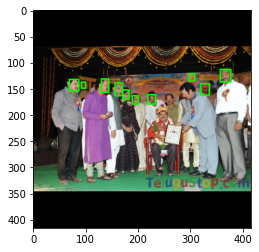

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


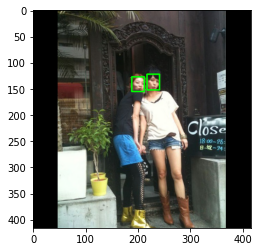

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


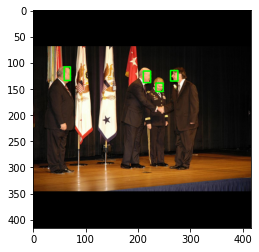

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


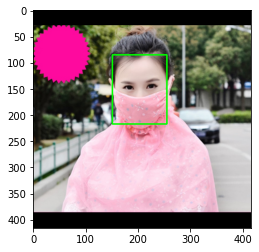

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


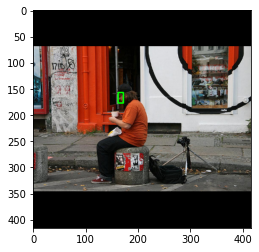

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


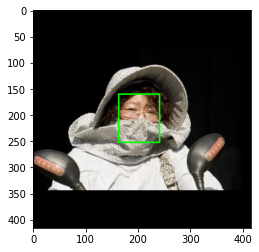

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


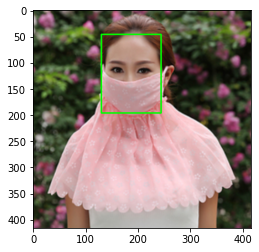

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


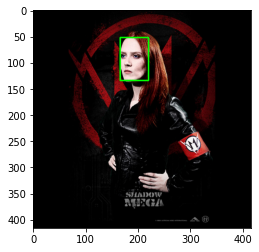

In [4]:
all_bboxes = []
batch,anchor_dim,_,_,p = predictions[0].shape
for s,pred,anchor in zip(scales,predictions,ANCHORS):
    if is_preds :
        anchor = np.array(anchor).reshape(1, anchor_dim, 1, 1, 2)
        pred[...,1:3] = tf.sigmoid(pred[...,1:3])
        pred[...,3:5] = tf.exp(pred[...,3:5])*anchor
    cell_x,cell_y = np.meshgrid(np.arange(s),np.arange(s),indexing='ij')
    pred[...,1:2] = (pred[...,1:2]+np.expand_dims(np.tile(cell_y.reshape(1,1,s,s),(batch,anchor_dim,1,1)),axis=-1))/s
    pred[...,2:3] = (pred[...,2:3]+np.expand_dims(np.tile(cell_x.reshape(1,1,s,s),(batch,anchor_dim,1,1)),axis=-1))/s
    pred[...,3:5] = pred[...,3:5]/s
    pred = pred.reshape(batch,anchor_dim*s*s,p)
    pred[...,1:5] = pred[...,1:5]*416
    new_pred = pred.copy()
    new_pred[...,1] = pred[...,1] - pred[...,3]//2 
    new_pred[...,2] = pred[...,2] - pred[...,4]//2 
    new_pred[...,3] = pred[...,1] + pred[...,3]//2 
    new_pred[...,4] = pred[...,2] + pred[...,4]//2 
    all_bboxes.append(new_pred)
new_bboxes = np.concatenate((all_bboxes[0],all_bboxes[1],all_bboxes[2]),axis=1).astype(np.int32)
for image,bbox in zip(images,new_bboxes):
    selected_indices  = tf.image.non_max_suppression(bbox[...,1:5],bbox[...,0],\
                                                 iou_threshold=0.8,max_output_size=10,score_threshold=0.8)
    selected_boxes = tf.gather(bbox, selected_indices)
    for i in selected_boxes:
        x1,y1,x2,y2 = i[1:5]
        image = cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),2)
    plt.imshow(image)
    plt.show()

In [5]:
model= get_model(input_shape=(416,416,3),num_classes=2)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
custom_loss = YOLOLOSS()

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [9]:
model.load_weights('my_model.h5',skip_mismatch=True,by_name=True)

OSError: Unable to open file (unable to open file: name = 'my_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
import time

In [ ]:
for epoch in range(1, 10):
    print('new epoch')
    batch_loss = []
    start = time.time()
    for batch, (images, labels) in enumerate(datagen):
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            pred_loss = []
            #for output, label, loss_fn in zip(outputs, labels, loss):
            #    pred_loss.append(loss_fn(label, output))
            total_loss = custom_loss.main_loss(outputs,labels)
            batch_loss.append(total_loss)
            print('total:',total_loss)
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables))
    print('time taken:',(time.time()-start),'loss:',np.mean(batch_loss))


new epoch
7.018566608428955 0.20764361321926117 1.159087061882019 0.8020372504048794
6.4150848388671875 0.26110130548477173 3.2401885986328125 0.8172113939372133
6.990728855133057 0.21514107286930084 8.072297096252441 0.7223791539142408
total: tf.Tensor(35.92146684902614, shape=(), dtype=float64)
3.8975441455841064 0.09167066961526871 2.4535470008850098 0.7292792198184818
5.157608509063721 0.049133770167827606 8.50855541229248 0.831111405702391
6.46281623840332 0.16217604279518127 11.4728364944458 0.6420045421979128
total: tf.Tensor(40.45828345097151, shape=(), dtype=float64)
3.591127395629883 0.18092595040798187 3.7628841400146484 0.6019741168056792
4.4544219970703125 0.18020057678222656 10.340020179748535 0.870570297583532
6.022679805755615 0.12253127247095108 11.038739204406738 0.7119726082247352
total: tf.Tensor(41.87804754490084, shape=(), dtype=float64)
3.310001850128174 0.04597608372569084 1.0323747396469116 0.6371572050750012
4.484162330627441 0.0996837243437767 2.8945138454437

In [ ]:
model.save('trained.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
x,y = datagen[0]

In [13]:
y[0].shape

(8, 3, 13, 13, 25)